# Bird Alert!

This image recognition app is designed to tell the difference between sulphur-crested cockatoos, galahs and little corellas. This script was initially run on paperspace, and I have just saved the mdel object and created a new notebook to experiment with productionising them.

In [1]:
# import the fastai modules
from fastbook import *
from fastai.vision.widgets import *

In [2]:
#  set up azure API key
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'API_KEY')

In [3]:
# search bing for sulpur crested cockatoos
results = search_images_bing(key, 'sulphur crested cockatoo')
ims = results.attrgot('contentUrl')
len(ims)

150

In [4]:
dest = 'images.cockatoo.jpg'
download_url(ims[0], dest)

Path('images.cockatoo.jpg')

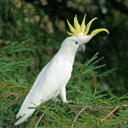

In [5]:
im = Image.open(dest)
im.to_thumb(128, 128)

In [6]:
# Success! now generalise to all my birdies
bird_types = 'sulphur crested cockatoo', 'galah', 'little corella'
path = Path('birds')

In [7]:
if not path.exists():
    path.mkdir()
    for birdy in bird_types:
        dest = (path/birdy)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, birdy)
        download_images(dest, urls=results.attrgot('contentUrl'))

In [9]:
# get file names (damn they dont like
fns = get_image_files(path)
fns

(#426) [Path('birds/sulphur crested cockatoo/00000047.jpg'),Path('birds/sulphur crested cockatoo/00000055.jpg'),Path('birds/sulphur crested cockatoo/00000107.jpg'),Path('birds/sulphur crested cockatoo/00000036.jpg'),Path('birds/sulphur crested cockatoo/00000030.jpg'),Path('birds/sulphur crested cockatoo/00000097.jpg'),Path('birds/sulphur crested cockatoo/00000148.jpg'),Path('birds/sulphur crested cockatoo/00000110.jpg'),Path('birds/sulphur crested cockatoo/00000029.jpg'),Path('birds/sulphur crested cockatoo/00000112.jpg')...]

In [10]:
failed = verify_images(fns)
failed

(#0) []

In [11]:
failed.map(Path.unlink);

In [12]:
# Create the datablock, which is the generic way to call the fastai api
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [30]:
# create the dataloaders (which is different to a dataloader)
dls = birds.dataloaders(path)

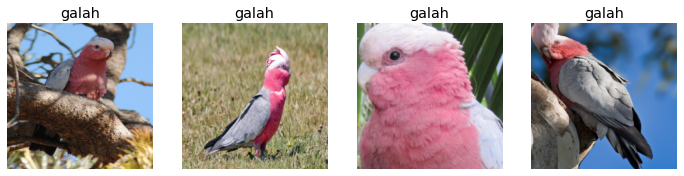

In [31]:
dls.valid.show_batch(max_n=4, nrows=1)

In [38]:
# data augmentation
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = birds.dataloaders(path)

In [39]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.617285,0.585388,0.200000,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.592198,0.404049,0.141176,00:10
1,0.492648,0.227426,0.082353,00:11
2,0.387794,0.161847,0.047059,00:10
3,0.311149,0.143189,0.047059,00:10
4,0.264979,0.138578,0.047059,00:10
5,0.222609,0.136482,0.047059,00:10


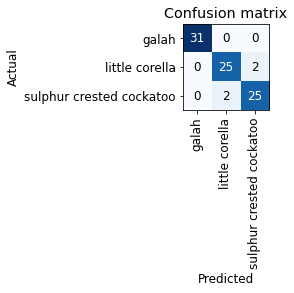

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

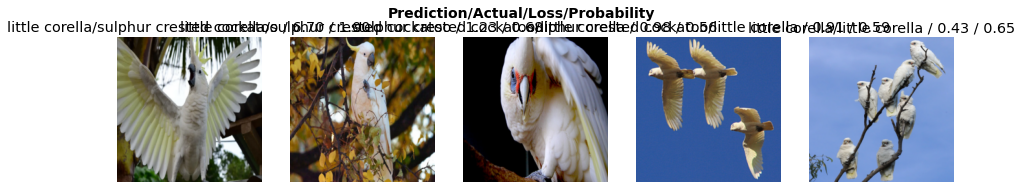

In [41]:
interp.plot_top_losses(5, nrows=1)

In [42]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [37]:
# apply the GUI changes
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Create a notebook app

In [45]:
learn.export()

In [46]:
path = Path()
path.ls(file_exts='pkl')

(#0) []

In [47]:
learn_inf = load_learner(path/'export.pkl')

In [48]:
learn_inf.predict('images.cockatoo.jpg')

('sulphur crested cockatoo',
 tensor(2),
 tensor([3.5269e-05, 1.0223e-04, 9.9986e-01]))

In [49]:
learn_inf.dls.vocab

['galah', 'little corella', 'sulphur crested cockatoo']

In [50]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [57]:
img = PILImage.create(btn_upload.data[-1])

In [58]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128, 128))
out_pl

Output()

In [59]:
pred,pred_idx,probs = learn_inf.predict(img)

In [60]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: galah; Probability: 0.9999')

In [61]:
btn_run = widgets.Button(description = "Classify")
btn_run

Button(description='Classify', style=ButtonStyle())

IndexError: list index out of range

In [62]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [63]:
btn_upload = widgets.FileUpload()

In [65]:
VBox([widgets.Label('Select your bird!'),
      btn_upload, btn_run, out_pl, lbl_pred])